In [1]:
%matplotlib inline
from autoRIFT import autoRIFT
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# !curl https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/7/V/EG/2020/5/S2B_7VEG_20200512_0_L2A/B08.tif --output S2B_7VEG_20200512_0_L2A_B08.tif
# !curl https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/7/V/EG/2020/5/S2A_7VEG_20200527_0_L2A/B08.tif --output S2A_7VEG_20200527_0_L2A_B08.tif

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  215M  100  215M    0     0  4067k      0  0:00:54  0:00:54 --:--:-- 5220k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  209M  100  209M    0     0  3943k      0  0:00:54  0:00:54 --:--:-- 3595k  0:00:32 2709k    0  0:00:56  0:00:39  0:00:17 3996k05 4187k


In [2]:
def run_autorift(reference, secondary, step=16, min_window=240, max_window=480, min_distance=0, max_distance=32):
    # intizialize
    obj = autoRIFT()

    # set imagery
    obj.I1 = reference.astype(np.float32)
    obj.I2 = secondary.astype(np.float32)

    # Sampling
    obj.SkipSampleX = step
    obj.SkipSampleY = step

    # Chip size
    obj.ChipSizeMinX = min_window
    obj.ChipSizeMaxX = max_window
    obj.ChipSize0X = float(16)
    obj.ScaleChipSizeY = int(1)

    # Search Area
    obj.minSearch = min_distance
    obj.SearchLimitX = max_distance
    obj.SearchLimitY = max_distance

    # Create Grid
    m, n = reference.shape
    xVals = np.arange(obj.SkipSampleX, n - obj.SkipSampleX, obj.SkipSampleX)
    yVals = np.arange(obj.SkipSampleY, m - obj.SkipSampleY, obj.SkipSampleY)
    ncol = int(xVals.shape[0])
    nrow = int(yVals.shape[0])
    xGrid = np.repeat(np.reshape(xVals, (1, ncol)), nrow, axis=0)
    yGrid = np.repeat(np.reshape(yVals, (nrow, 1)), ncol, axis=1)
    obj.xGrid = xGrid
    obj.yGrid = yGrid

    # Run autoRIFT
    obj.uniform_data_type()
    obj.preprocess_filt_hps()
    obj.autorift()

    return obj


def load_gdal(infile, band=1):
    ds = gdal.Open(infile, gdal.GA_ReadOnly)

    data = ds.GetRasterBand(band).ReadAsArray()
    nodata = ds.GetRasterBand(band).GetNoDataValue()
    mask = data == nodata
    data = np.ma.array(data, mask=mask, fill_value=-9999)
    projection = ds.GetProjection()
    transform = ds.GetGeoTransform()
    ds = None
    return data, transform, projection



In [3]:
bounds = np.s_[1000:7500, 0:5000]
ref, _, _ = load_gdal('S2B_7VEG_20200512_0_L2A_B08.tif')
ref = ref[bounds]
sec, _, _ = load_gdal('S2A_7VEG_20200527_0_L2A_B08.tif')
sec = sec[bounds]

In [4]:
step = 16
result = run_autorift(ref, sec, step=step)

[[  16   32   48 ... 4944 4960 4976]
 [  16   32   48 ... 4944 4960 4976]
 [  16   32   48 ... 4944 4960 4976]
 ...
 [  16   32   48 ... 4944 4960 4976]
 [  16   32   48 ... 4944 4960 4976]
 [  16   32   48 ... 4944 4960 4976]]


SystemExit: xgrid and ygrid have an incorect size (405, 311) for nested search, they must have dimensions that an interger multiple of 16.0

/Users/ffwilliams2/miniconda3/envs/autorift3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [14]:
%tb

SystemExit: xgrid and ygrid have an incorect size (390, 300) for nested search, they must have dimensions that an interger multiple of 16.0

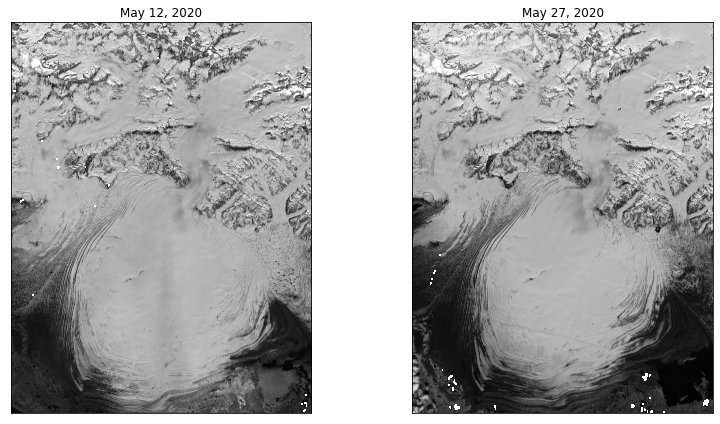

In [85]:
img_color_opts = {'vmin': 0, 'vmax': 12000, 'cmap': 'Greys_r'}

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

dx_plot = ax1.imshow(ref, **img_color_opts)
ax1.set(title='May 12, 2020', xticks=[], yticks=[])

dy_plot = ax2.imshow(sec, **img_color_opts)
ax2.set(title='May 27, 2020', xticks=[], yticks=[])

f.tight_layout()

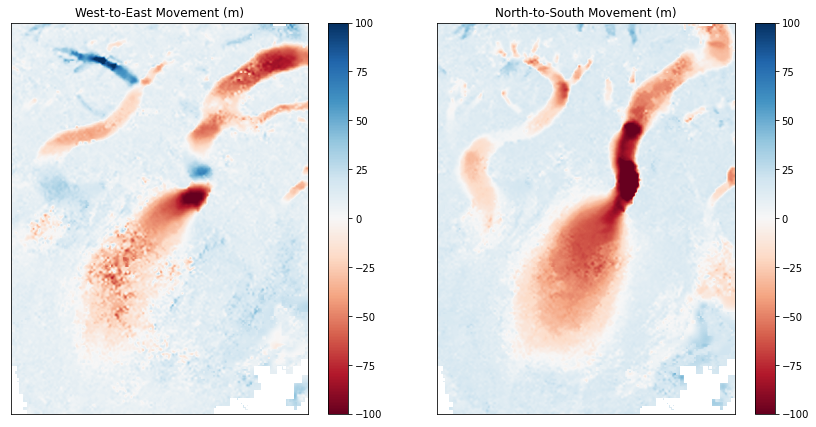

In [87]:
vel_color_opts = {'vmin':-100, 'vmax':100, 'cmap':'RdBu'}

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

dx_plot = ax1.imshow(result.Dx * step, **vel_color_opts)
ax1.set(title='West-to-East Movement (m)', xticks=[], yticks=[])

dy_plot = ax2.imshow(result.Dy * step, **vel_color_opts)
ax2.set(title='North-to-South Movement (m)', xticks=[], yticks=[])

f.colorbar(dx_plot, ax=ax1)
f.colorbar(dy_plot, ax=ax2)
f.tight_layout()